In [2]:
devtools::install_github("ClairBarnes/rwwa")
suppressMessages(library("rwwa"))

Skipping install of 'rwwa' from a github remote, the SHA1 (533d8a6e) has not changed since last install.
  Use `force = TRUE` to force installation



# Trend fitting - precip ~ GMST

## DJF or JJ

In [3]:
gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- data.frame(gmst = 0)
cov_cf <- data.frame(gmst = c("pi" = -1.2, "2000" = -0.5))

In [4]:
datasets <- list("era5" = "era5-05", "mswx" = "mswx", "chirps" = "chirps")

datasets_djf <- sapply(datasets, function(ds) load_ts(paste0("ts_obs/pantanal-fires_pr-djf_",ds,".dat"), col.names = c("year", "pr")), simplify = F)        
datasets_jj <- sapply(datasets, function(ds) load_ts(paste0("ts_obs/pantanal-fires_pr-jj_",ds,".dat"), col.names = c("year", "pr")), simplify = F)

## Check normality

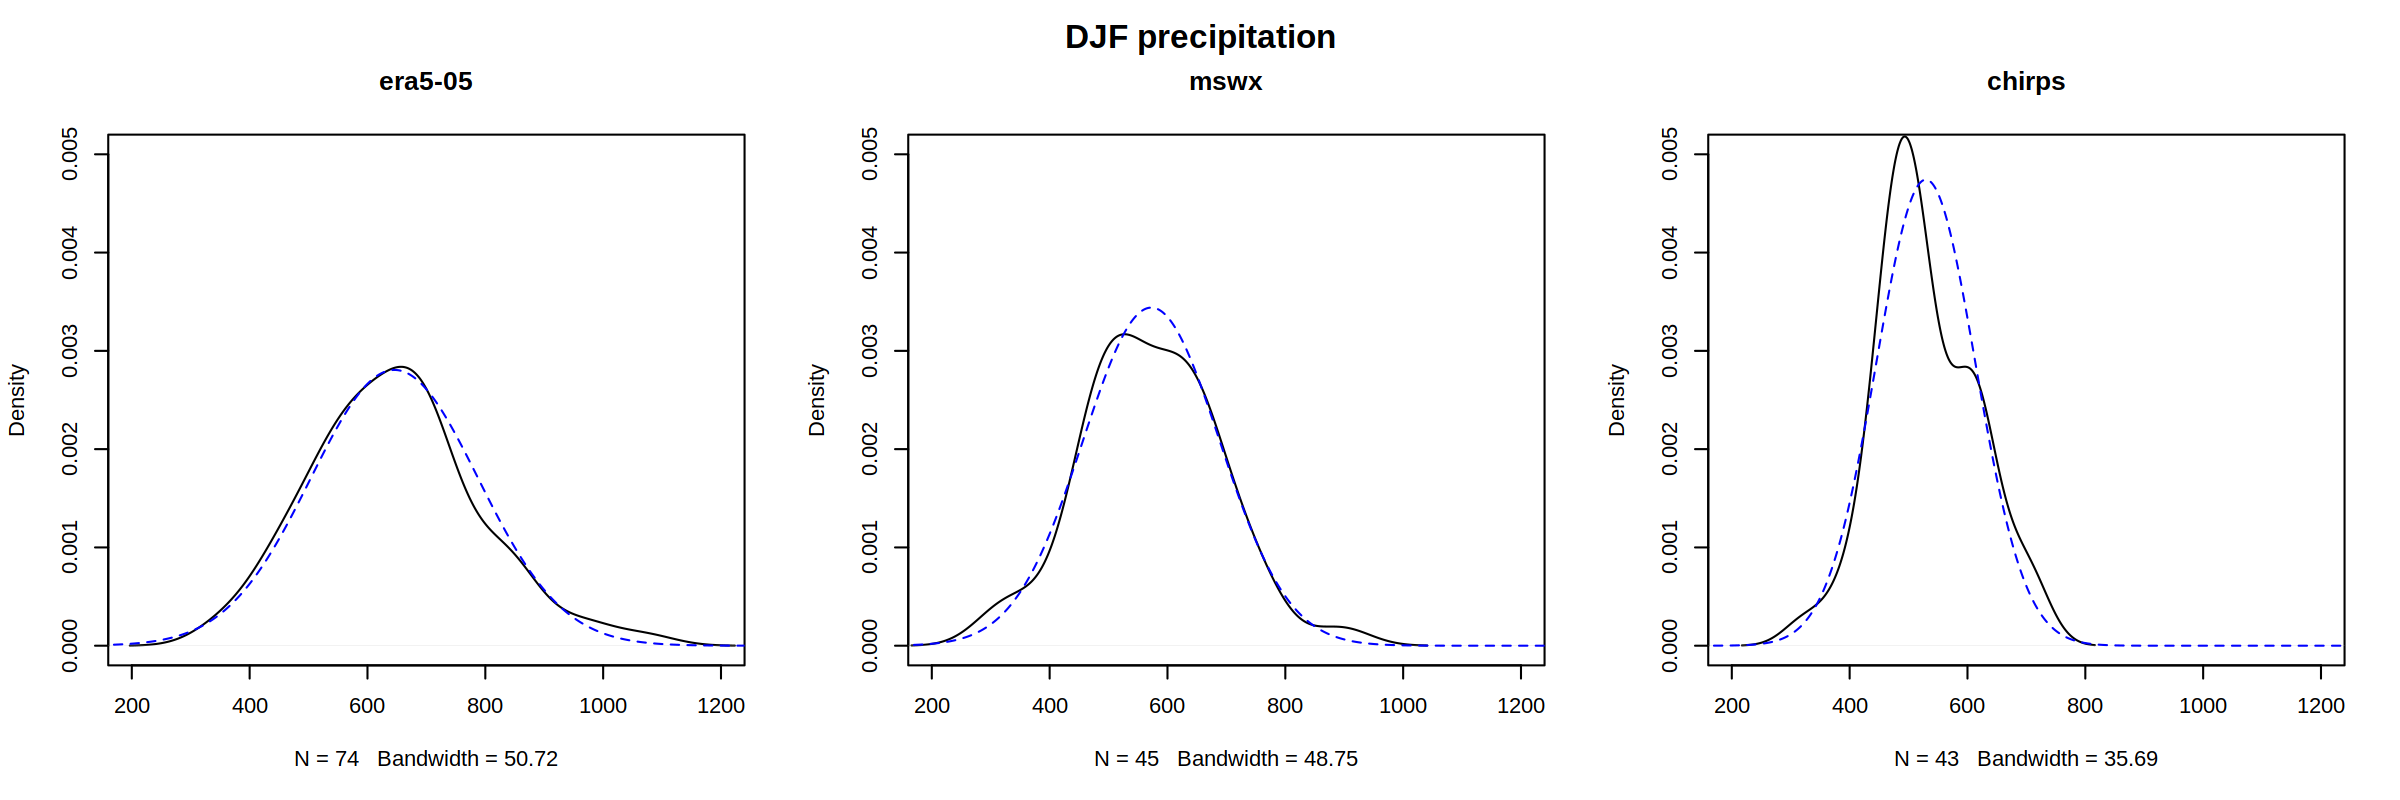

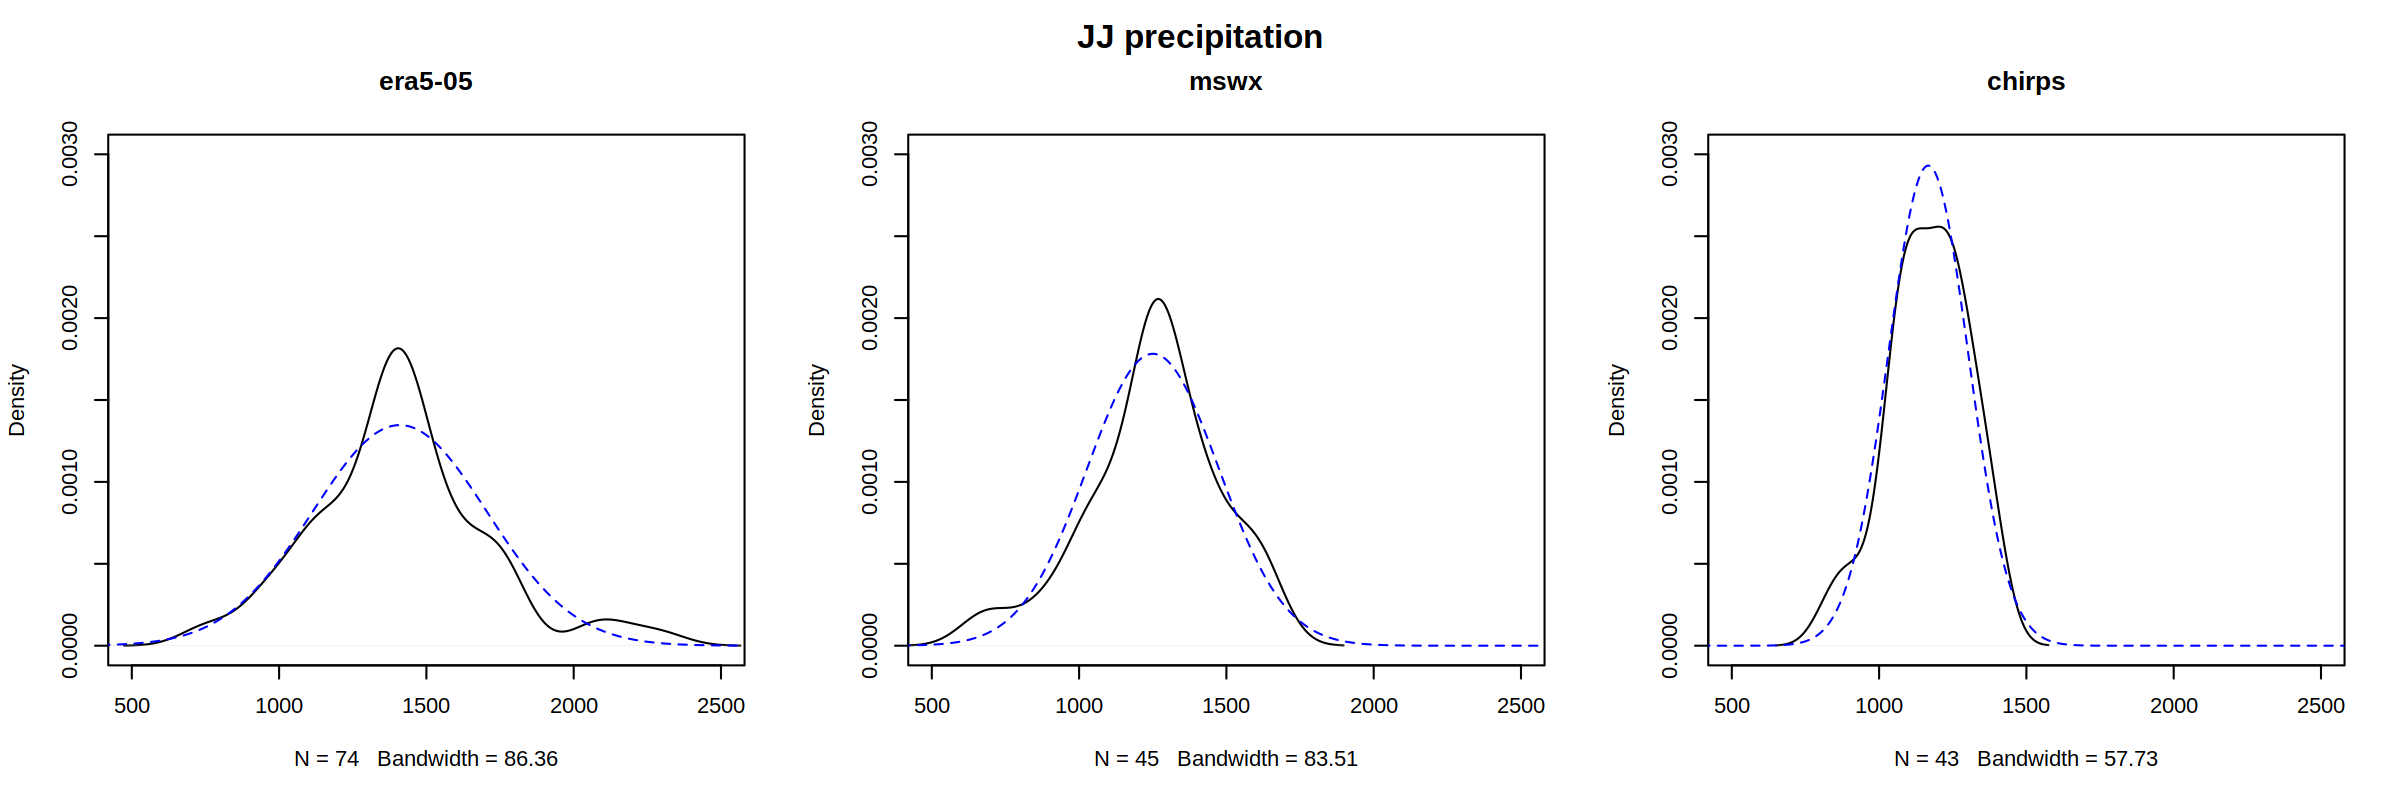

In [5]:
for (s in c("djf", "jj")) {
    
#     png(paste0("fig/precip-kde_",s,".png"), height = 240, width = 360 * 3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        for (i in 1:3) {
            
            ts <- get(paste0("datasets_",s))[[i]]$pr
            ylim <- switch(s, "djf" = c(0,0.005), "jj" = c(0,0.003))
            xlim <- switch(s, "djf" = c(200,1200), "jj" = c(500,2500))
            x <- switch(s, "djf" = 0:1500, "jj" = 0:3000)
            plot(density(ts), ylim = ylim, xlim = xlim, main = datasets[[i]])
            lines(x, dnorm(x, mean(ts), sd(ts)), col = "blue", lty = 2)
        }
        mtext(paste(toupper(s), "precipitation"), outer = T, font = 2, line = -1)
#     }; dev.off()
}

## Compare model fit

In [39]:
# shift or scale?
rbind("shift" = sapply(datasets_djf, function(df) aic(fit_ns("norm", "shift", merge(gmst, df), "pr", c("gmst"), lower = T))),
      "scale" = sapply(datasets_djf, function(df) aic(fit_ns("norm", "fixeddisp", merge(gmst, df), "pr", c("gmst"), lower = T))))
                       
rbind("shift" = sapply(datasets_jj, function(df) aic(fit_ns("norm", "shift", merge(gmst, df), "pr", c("gmst"), lower = T))),
      "scale" = sapply(datasets_jj, function(df) aic(fit_ns("norm", "fixeddisp", merge(gmst, df), "pr", c("gmst"), lower = T))))

,era5,mswx,chirps
shift,940.9056,547.4618,506.8267
scale,939.1722,549.2944,507.3922


,era5,mswx,chirps
shift,1044.261,592.7710,546.5386
scale,1039.491,595.8889,547.8735


In [5]:
models_djf <- sapply(datasets_djf, function(df) fit_ns("norm", "fixeddisp", merge(gmst, df), "pr", c("gmst"), lower = T), simplify = F)
models_jj <- sapply(datasets_jj, function(df) fit_ns("norm", "fixeddisp", merge(gmst, df), "pr", c("gmst"), lower = T), simplify = F)

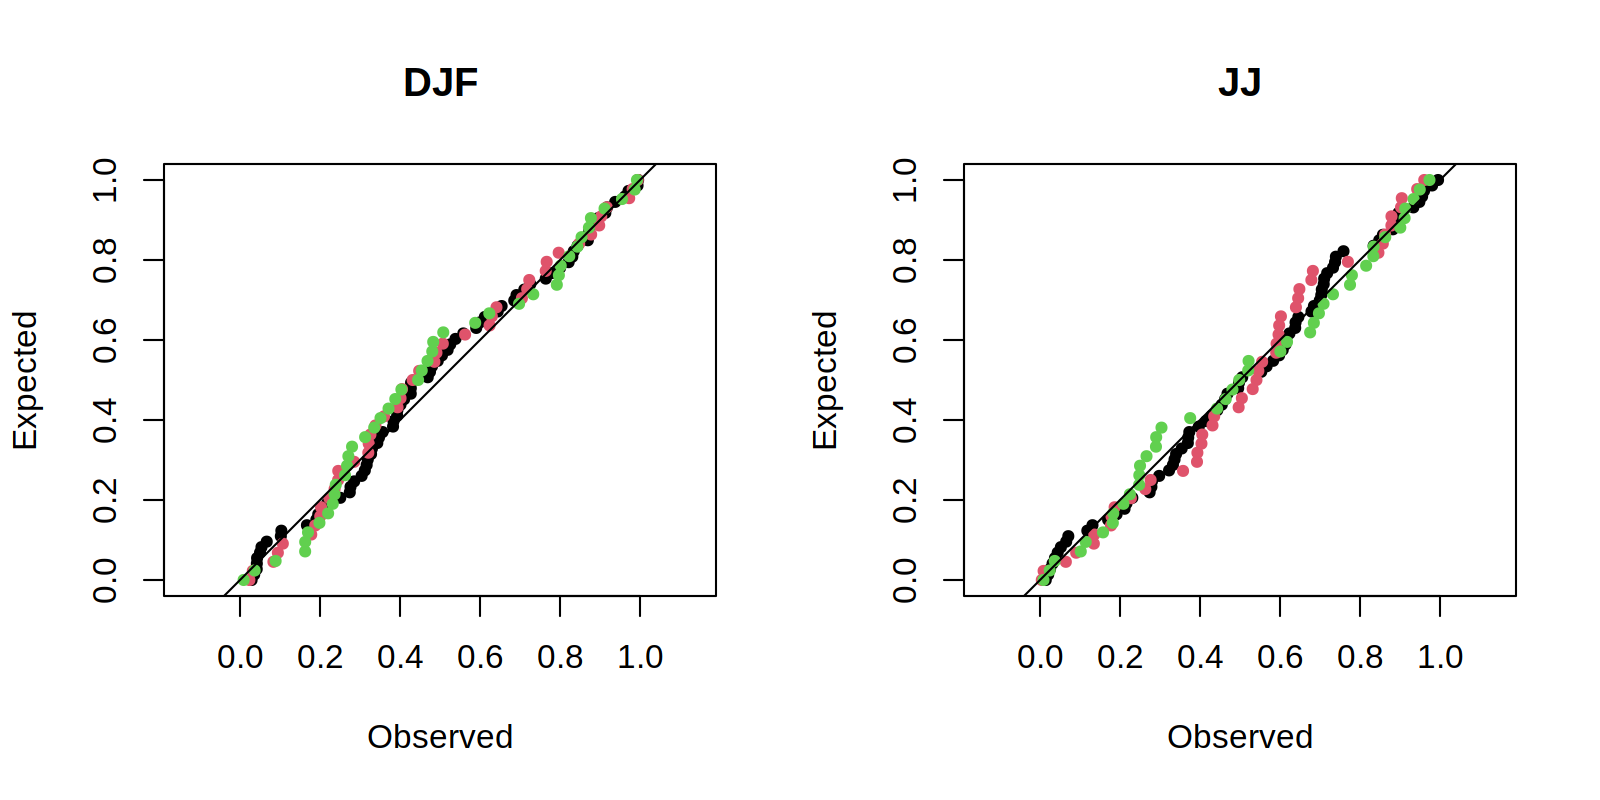

In [22]:
# Q-Q plot of fitted data
prep_window(c(1,2))

for (s in c("djf", "jj")) {
    
    plot(0, type = "n", xlim = c(0,1), ylim = c(0,1), asp = T, xlab = "Observed", ylab = "Expected", main = toupper(s))
    
    for (i in 1:3) {

            mdl <- get(paste0("models_",s))[[i]]
            points(sort(map_to_u(mdl)), seq(0,1,length.out = length(mdl$x)), col = i)
        }
    abline(0,1)
}

In [28]:
for (s in c("djf", "jj")) {
    
    png(paste0("fig/trend-vs-time_precip_",s,".png"), height = 240, width = 360 * 3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        for (i in 1:3) {

            mdl <- get(paste0("models_",s))[[i]]
            ylim <- switch(s, "djf" = c(0,1200), "jj" = c(0,2500))
            plot_trend(mdl, add_loess = T, main = datasets[[i]], ylim = ylim)
        }
        mtext(paste(toupper(s), "precipitation"), outer = T, font = 2, line = -1)
    }; dev.off()
}

In [7]:
for (s in c("djf", "jj")) {
    
    png(paste0("fig/trend-vs-gmst_precip_",s,".png"), height = 240, width = 360 * 3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        for (i in 1:3) {

            mdl <- get(paste0("models_",s))[[i]]
            ylim <- switch(s, "djf" = c(0,1200), "jj" = c(0,2500))
            plot_covtrend(mdl, "gmst", add_loess = T, main = datasets[[i]], ylim = ylim)
        }
        mtext(paste(toupper(s), "precipitation"), outer = T, font = 2, line = -1)
    }; dev.off()
}

In [24]:
for (s in c("djf", "jj")) {
    
    png(paste0("fig/rlplots_precip_",s,".png"), height = 240, width = 360 * 3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        for (i in 1:3) {

            mdl <- get(paste0("models_",s))[[i]]
            ylim <- switch(s, "djf" = c(0,1200), "jj" = c(0,2500))
            plot_returnlevels(mdl, cov_f = cov_2024, cov_cf = cov_cf["2000",,drop = F], main = datasets[[i]], nsamp = 50, ylim = ylim)
        }
        mtext(paste(toupper(s), "precipitation"), outer = T, font = 2, line = -1)
    }; dev.off()
}

In [19]:
round(rbind("DJF" = sapply(models_djf, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("return_period"),],
            "Annual" = sapply(models_jj, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("return_period"),]))

,era5,mswx,chirps
DJF,28,43,11
Annual,40,226,115


In [22]:
round(rbind("DJF" = sapply(models_djf, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("PR_pi"),],
            "Annual" = sapply(models_jj, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("PR_pi"),]),1)

,era5,mswx,chirps
DJF,6,38.6,2.5
Annual,17,206.7,6.1


In [23]:
round(rbind("DJF" = sapply(models_djf, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("dI_rel_pi"),],
            "Annual" = sapply(models_jj, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("dI_rel_pi"),]),1)

,era5,mswx,chirps
DJF,-23.3,-34.7,-9.0
Annual,-29.6,-34.2,-9.3


## Precip ~ GMST + Nino

- contribution from El Nino is minimal so won't pursue further

In [42]:
gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

nino <- load_ts("ts_obs//pantanal-fires_nino-djf_ersst.dat", col.names = c("year", "nino"))

df <- merge(gmst, nino)

cov_2024 <- df[df$year == 2024,c("gmst", "nino"),drop = F]
cov_cf <- rbind("pi" = cov_2024 - c(1.2,0), "2000" = cov_2024 - c(0.5,0), "neut" = c(0,0), "neuthist" = c(-1.2,0))

In [43]:
datasets <- list("era5" = "era5-05", "mswx" = "mswx", "chirps" = "chirps")

datasets_djf <- sapply(datasets, function(ds) load_ts(paste0("ts_obs/pantanal-fires_pr-djf_",ds,".dat"), col.names = c("year", "pr")), simplify = F)        
datasets_jj <- sapply(datasets, function(ds) load_ts(paste0("ts_obs/pantanal-fires_pr-jj_",ds,".dat"), col.names = c("year", "pr")), simplify = F)

In [44]:
models_djf <- sapply(datasets_djf, function(ts) fit_ns("norm", "fixeddisp", merge(df, ts), "pr", c("gmst", "nino"), lower = T), simplify = F)
models_jj <- sapply(datasets_jj, function(ts) fit_ns("norm", "fixeddisp", merge(df, ts), "pr", c("gmst", "nino"), lower = T), simplify = F)

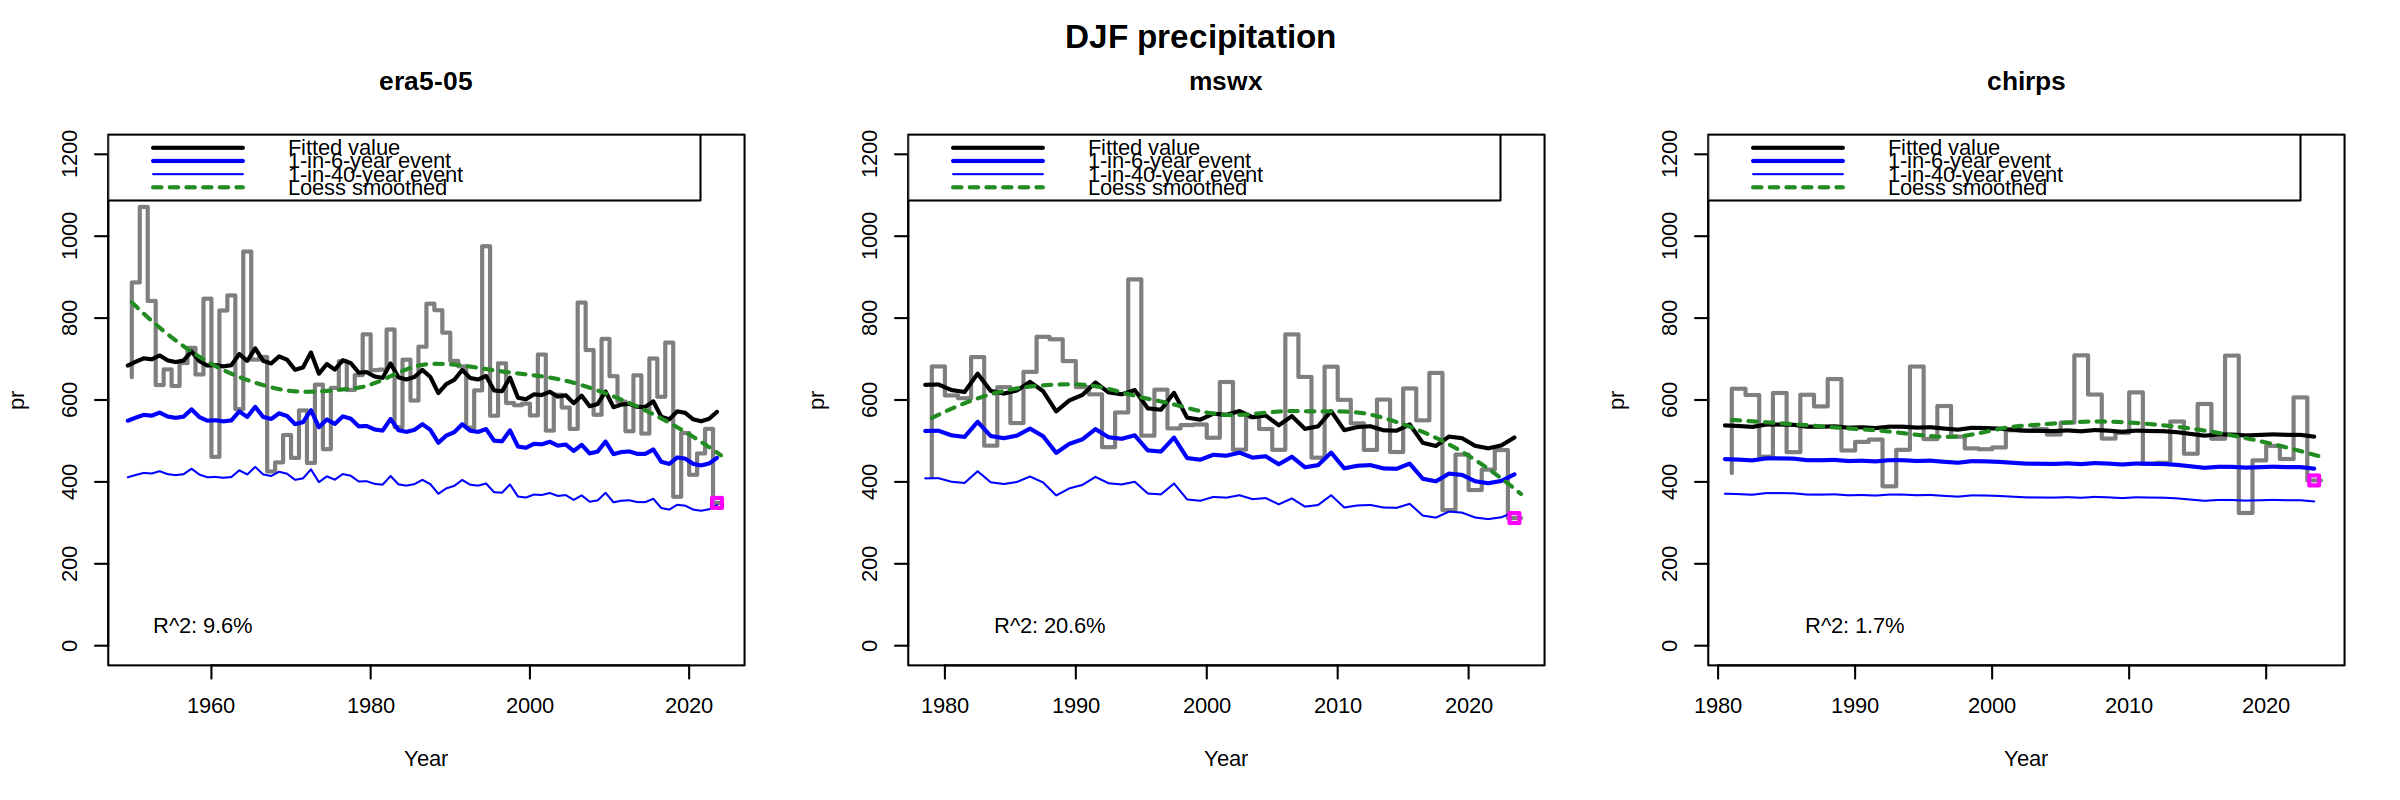

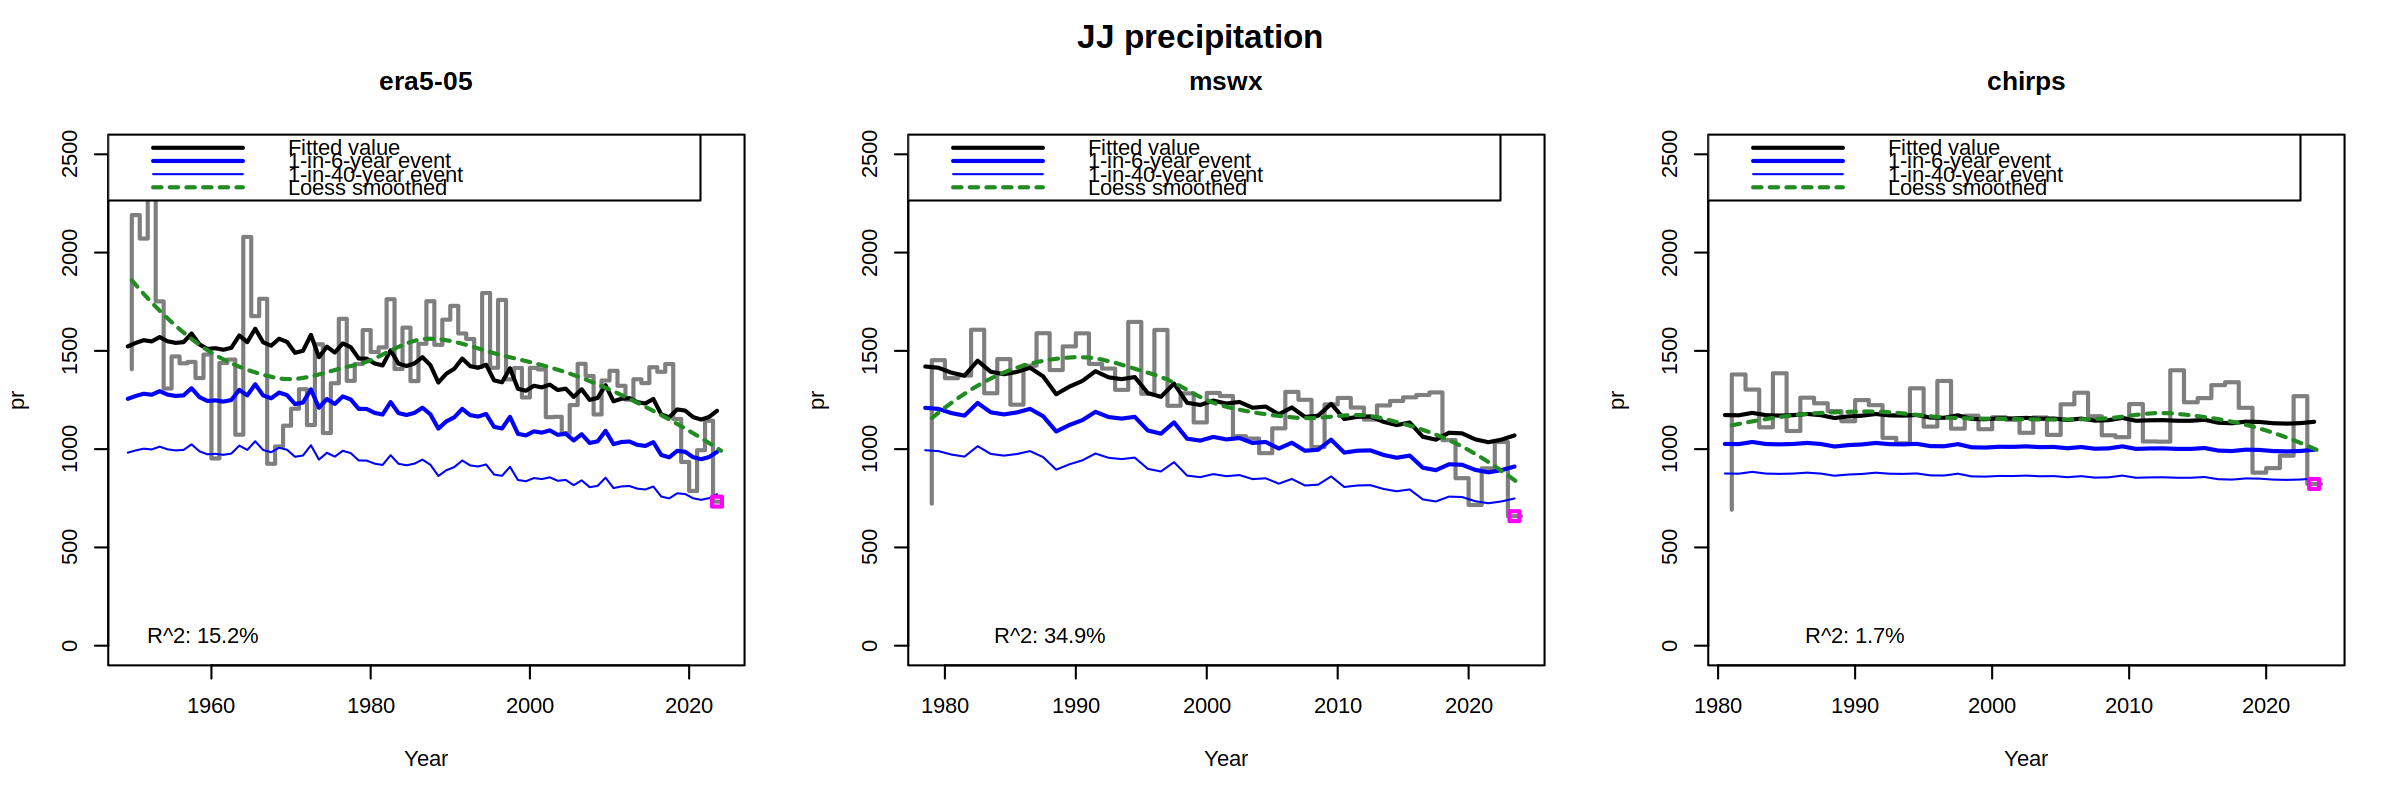

In [43]:
for (s in c("djf", "jj")) {
    
    prep_window(c(1,3), oma = c(0,0,1,0))
    for (i in 1:3) {

        mdl <- get(paste0("models_",s))[[i]]
        ylim <- switch(s, "djf" = c(0,1200), "jj" = c(0,2500))
        plot_trend(mdl, add_loess = T, main = datasets[[i]], ylim = ylim)
        text(mdl$data$year[10],50, paste0(expression(R^2), ": ",round(rsquared(mdl)["r2"] * 100,1),"%"))
    }
    mtext(paste(toupper(s), "precipitation"), outer = T, font = 2, line = -1)
}

In [45]:
for (s in c("djf", "jj")) {
    
    png(paste0("fig/trend-vs-nino_precip_",s,".png"), height = 240, width = 360 * 3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
    for (i in 1:3) {

        mdl <- get(paste0("models_",s))[[i]]
        ylim <- switch(s, "djf" = c(0,1200), "jj" = c(0,2500))
        plot_covtrend(mdl, "nino", add_loess = T, main = datasets[[i]], ylim = ylim)
        text(-1.5,50, paste0(expression(R^2), ": ",round(rsquared(mdl)["r2"] * 100,1),"%"))
    }
    mtext(paste(toupper(s), "precipitation"), outer = T, font = 2, line = -1)
    }; dev.off()
}

## Quick seasonal model results


In [42]:
gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- df[df$year == 2024,c("gmst",),drop = F]
cov_cf <- rbind("pi" = cov_2024 - c(1.2), "2000" = cov_2024 - c(0.5))

In [13]:
datasets <- list("era5" = "era5", "mswx" = "mswx", "chirps" = "chirps")
seasons <- c("JJA", "SON", "DJF", "MAM")

data <- sapply(datasets, function(ds) read.csv(paste0("data/pr_seasonal_pantanal_",ds,".csv"), col.names = c("year", seasons)), simplify = F)        

In [24]:
models <- sapply(data, function(df) sapply(seasons, function(s) fit_ns("norm", "fixeddisp", merge(gmst, df), toupper(s), c("gmst"), lower = T), simplify = F), simplify = F)

In [25]:
sapply(models, function(mlist) sapply(mlist, function(mdl) return_period(mdl, mdl$ev, fixed_cov = cov_2024), simplify = T), simplify = T)

,era5,mswx,chirps
JJA,3.474213,2.908366,3.12949
SON,43.940843,51.775475,21.23956
DJF,28.135379,42.641973,11.22737
MAM,1.162944,1.139318,1.26894


In [36]:
t(round(sapply(models, function(mlist) sapply(mlist, function(mdl) int_change(mdl, 50, cov_f = cov_2024, cov_cf = cov_cf["2000",,drop = F], relative = T), simplify = T), simplify = T),1))

,JJA,SON,DJF,MAM
era5,-20.1,-14.5,-10.5,-16.6
mswx,-30.9,-22.2,-16.3,-16.8
chirps,-4.2,3.6,-3.8,-1.8


In [37]:
t(round(sapply(models, function(mlist) sapply(mlist, function(mdl) int_change(mdl, 10, cov_f = cov_2024, cov_cf = cov_cf["2000",,drop = F], relative = F), simplify = T), simplify = T),1))

,JJA,SON,DJF,MAM
era5,-4.8,-29.3,-47.8,-33.0
mswx,-8.3,-42.4,-72.4,-37.4
chirps,-1.4,7.1,-16.3,-3.6
